## Recurrent Network - 2nd Part

LSTM was proposed in 1997 by Sepp Hochreiter and Jürgen Schmidhuber. It is an artificial **recurrent neural network (RNN) architecture**, developed to deal with the **exploding and vanishing gradient problems** that can be encountered when training traditional RNNs.

In this lessson, we would introduce several parts below:

1. Some application of LSTM, eg., Seq2Seq  
    1.1 Naive implementation of Seqseq translation model  
    1.2 Naive implementation of Seqseq translation model with attention mechanism
2. More about LSTM  
    2.1 Exploring the inner structrue of LSTM (Implement LSTM from scratch using pytorch)      
    2.2 Comparing LSTM with RNN on change of the grad, when input is a very long sequence   
    2.3 Observing the forget gate, input gate and output gate of LSTM   
    
This tutorials mainly refer from [seq2seq_translation_tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) and [Building an LSTM from Scratch in PyTorch ](http://mlexplained.com/2019/02/15/building-an-lstm-from-scratch-in-pytorch-lstms-in-depth-part-1/).

## Load Necessary modules

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import random
import math
import time

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from typing import *
from torch.nn import Parameter
from torch.nn import init
from torch import Tensor
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

Since process of data isn't the center part that we should focus in this tutorials,
we put data related code in **utils** function.    
Actually, if we want to solve a problem seriously, there is no way for us to skip data processing, which may be boring but very important. 

In [2]:
from utils import *

In [3]:
# Determine to use GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def setup_seed(seed):
    """In order to reproduce the same results
    Args: 
        seed: random seed given by you
    """
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

## 1.1 Naive implementation of Seqseq translation model  
Seq2seq translation model consists of two parts, including the **Encoder** and **Decoder**.   
Encoder encodes source sentences into fixed vectors for decoder.  
Decoder decode fixed vectors into target sentences.

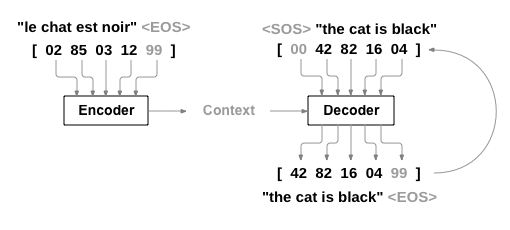

## 1.1.1 The Encoder


The encoder of a seq2seq network is a LSTM that outputs some value for every word from the input sentence.   
For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the
next input word.

In [5]:
class EncoderLSTM(nn.Module):
    """Encoder use LSTM as backbone"""
    def __init__(self, input_size: int, hidden_size: int):
        """
        Args:
            input_size : The number of expected features in the input 
            hidden_size: The number of features in the hidden state 
        """
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        # Retrieve word embeddings with dimentionality hidden_size 
        # using indices with dimentionality input_size, embeddding is learnable
        # After embedding, input vector with input_size would be converted to hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        # LSTM 
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        
    def forward(self, inputs: Tensor, state: Tuple[Tensor]):
        """Forward
        Args:
            inputs: [1, hidden_size]
            state : ([1, 1, hidden_size], [1, 1, hidden_size])
        Returns:
            output:
            state: (hidden, cell)
        """
        (hidden, cell) = state
        # Retrieve word embeddings
        embedded = self.embedding(inputs).view(1, 1, -1)
        # Directly output embedding
        output = embedded
        output, (hidden, cell) = self.lstm(output, (hidden, cell))
        return output, (hidden, cell)
    
    def init_hidden(self):
        """Init hidden
        Returns:
            hidden:
            cell:
        """
        cell = torch.zeros(1, 1, self.hidden_size, device=device)
        hidden = torch.zeros(1, 1, self.hidden_size, device=device)
        return hidden, cell

## 1.1.2 The Decoder

The decoder is another LSTM that takes the encoder output vector(s) and outputs a sequence of words to create the translation.

In the simplest seq2seq decoder we use only last output of the encoder. 

This last output is sometimes called the context vector as it encodes context from the entire sequence. 

This context vector is used as the initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and hidden state. 

The initial input token is the start-of-string <SOS> token, and the first hidden state is the context vector (the encoder’s last hidden state).

In [6]:
class DecoderLSTM(nn.Module):
    """Decoder use LSTM as backbone"""
    def __init__(self, hidden_size: int, output_size: int):
        """
        Args:
            hidden_size: The number of features in the hidden state 
            output_size : The number of expected features in the output 
        """
        super(DecoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        # Retrieve word embeddings with dimentionality hidden_size 
        # using indices with dimentionality input_size, embeddding is learnable
        # After embedding, input vector with input_size would be converted to hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        # LSTM
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        # out
        self.out = nn.Linear(hidden_size, output_size)
        # log after softmax
        self.log_softmax = nn.LogSoftmax(dim=1)
        # activation function
        self.activation_function = F.relu
        
    def forward(self, inputs, state):
        """Forward
        Args:
            inputs: [1, hidden_size]
            state : ([1, 1, hidden_size], [1, 1, hidden_size])
        Returns:
            output:
            state: (hidden, cell)
        """
        (hidden, cell) = state
        # Retrieve word embeddings, [1, 1, hidden_size]
        output = self.embedding(inputs).view(1, 1, -1)
        # activation function, [1, 1, hidden_size]
        output = self.activation_function(output)
        # output: [1, 1, hidden_size]
        output, (hidden, cell) = self.lstm(output, (hidden, cell))
        # output: [output_size]
        output = self.log_softmax(self.out(output[0]))
        return output, (hidden, cell)

    def init_hidden(self):
        """Init hidden
        Returns:
            hidden:
            cell:
        """
        cell = torch.zeros(1, 1, self.hidden_size, device=device)
        hidden = torch.zeros(1, 1, self.hidden_size, device=device)
        return hidden, cell

## 1.1.3 Train and Evaluate

In [7]:
def train_by_sentence(input_tensor, target_tensor, encoder, decoder, 
                      encoder_optimizer, decoder_optimizer, loss_fn, 
                      use_teacher_forcing=True, reverse_source_sentence=True,
                      max_length=MAX_LENGTH):
    """Train by single sentence using EncoderLSTM and DecoderLSTM
       including training and update model
    Args:
        input_tensor: [input_sequence_len, 1, hidden_size]
        target_tensor: [target_sequence_len, 1, hidden_size]
        encoder: EncoderLSTM
        decoder: DecoderLSTM
        encoder_optimizer: optimizer for encoder
        decoder_optimizer: optimizer for decoder
        loss_fn: loss function
        use_teacher_forcing: True is to Feed the target as the next input, 
                             False is to use its own predictions as the next input
        max_length: max length for input and output
    Returns:
        loss: scalar
    """
    if reverse_source_sentence:
        input_tensor = torch.flip(input_tensor, [0])
        
    hidden, cell = encoder.init_hidden()

    # Clears the gradients of all optimized torch.Tensors'
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Get sequence length of the input and target sentences.
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    # encoder outputs:  [max_length, hidden_size]
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    # Get encoder outputs
    for ei in range(input_length):
        encoder_output, (hidden, cell) = encoder(
            input_tensor[ei], (hidden, cell))
        encoder_outputs[ei] = encoder_output[0, 0]
    
    # First input for the decoder
    decoder_input = torch.tensor([[SOS_token]], device=device)
    
    # Last state of encoder as the init state of decoder
    decoder_hidden = (hidden, cell)

    for di in range(target_length):
        decoder_output, (hidden, cell) = decoder(
            decoder_input, (hidden, cell))
        
        if use_teacher_forcing:
            # Feed the target as the next input
            loss += loss_fn(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing
        else:
            # Use its own predictions as the next input
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()
            loss += loss_fn(decoder_output, target_tensor[di])

        # End if decoder output End of Signal(EOS)
        if decoder_input.item() == EOS_token:
            break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [8]:
def train(encoder, decoder, n_iters, reverse_source_sentence=True, 
          use_teacher_forcing=True,
          print_every=1000, plot_every=100, 
          learning_rate=0.01):
    """Train of Seq2seq
    Args:
        encoder: EncoderLSTM
        decoder: DecoderLSTM
        n_iters: train with n_iters sentences without replacement
        reverse_source_sentence: True is to reverse the source sentence 
                                 but keep order of target unchanged,
                                 False is to keep order of the source sentence 
                                 target unchanged
        use_teacher_forcing: True is to Feed the target as the next input, 
                             False is to use its own predictions as the next input
        print_every: print log every print_every 
        plot_every: plot every plot_every 
        learning_rate: 
        
    """
    
    start = time.time()
    
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0

    # Use SGD to optimize encoder and decoder parameters
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    # Obtain training input 
    training_pairs = [tensor_from_pair(random.choice(pairs), input_lang, output_lang)
                      for _ in range(n_iters)]
    
    # Negative log likelihood loss
    loss_fn = nn.NLLLoss()

    for i in range(1, n_iters+1):
        # Get a pair of sentences and move them to device, 
        # training_pair: ([Seq_size, 1, input_size], [Seq_size, 1, input_size])
        training_pair = training_pairs[i-1]
        input_tensor = training_pair[0].to(device)
        target_tensor = training_pair[1].to(device)            
            
        # Train by a pair of source sentence and target sentence
        loss = train_by_sentence(input_tensor, target_tensor, 
                                 encoder, decoder,
                                 encoder_optimizer, decoder_optimizer, 
                                 loss_fn, use_teacher_forcing=use_teacher_forcing,
                                 reverse_source_sentence=reverse_source_sentence)
        
        print_loss_total += loss
        plot_loss_total += loss

        if i % print_every == 0:
            # Print Loss
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print("%s (%d %d%%) %.4f" % (time_since(start, i / n_iters),
                                         i, i / n_iters * 100, print_loss_avg))

        if i % plot_every == 0:
            # Plot
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    
    # show plot
    show_plot(plot_losses)

In [9]:
def evaluate_by_sentence(encoder, decoder, sentence, reverse_source_sentence, max_length=MAX_LENGTH):
    """Evalutae on a source sentence
    Args:
        encoder
        decoder
        sentence
        max_length
    Return:
        decoded_words: predicted sentence
    """
    with torch.no_grad():
        # Get tensor of sentence
        input_tensor = tensor_from_sentence(input_lang, sentence).to(device)
        input_length = input_tensor.size(0)
        
        if reverse_source_sentence:
            input_tensor = torch.flip(input_tensor, [0])
        
        # init state for encoder
        (hidden, cell) = encoder.init_hidden()

        # encoder outputs: [max_length, hidden_size]
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, (hidden, cell) = encoder(input_tensor[ei],
                                                     (hidden, cell))
            encoder_outputs[ei] += encoder_output[0, 0]
            
        # Last state of encoder as the init state of decoder
        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = (hidden, cell)
        decoded_words = []

        # When evaluate, use its own predictions as the next input
        for di in range(max_length):
            decoder_output, (hidden, cell) = decoder(decoder_input, (hidden, cell))
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append("<EOS>")
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])
                
            decoder_input = topi.squeeze().detach()

    return decoded_words

In [10]:
def evaluate_randomly(encoder, decoder, n=10, reverse_source_sentence=True):
    """Random pick sentence from dataset and observe the effect of translation
    Args:
        encoder: 
        decoder:
        n: numbers of sentences to evaluate
    """
    for _ in range(n):
        pair = random.choice(pairs)
        # Source sentence
        print(">", pair[0])
        # Target sentence
        print("=", pair[1])
        output_words = evaluate_by_sentence(encoder, decoder, pair[0], reverse_source_sentence)
        output_sentence = " ".join(output_words)
        # Predicted sentence
        print("<", output_sentence)
        print("")

In [11]:
def show_plot(points):
    """Plot according to points"""
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

## 1.1.4 Let's load data and train
Using **prepare_data** function to obtain sentences as pairs (source sentence, target sentence).

In [19]:
# prepare_data defined in utis.py 
# reverse to True here means, source sentence is English, 
# while target sentence is France
input_lang, output_lang, pairs = prepare_data('eng', 'fra', reverse=True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Reverse source sentence
Trimmed to 10599 sentence pairs
Counting words ...
Counting words:
fra 4345
eng 2803
['elle n est pas sans argent .', 'she s not penniless .']


In [14]:
setup_seed(45)
hidden_size = 256
# Reverse the order of source input sentence
reverse_source_sentence = True
# Feed the target as the next input
use_teacher_forcing = True
encoder = EncoderLSTM(input_lang.n_words, hidden_size).to(device)
decoder = DecoderLSTM(hidden_size, output_lang.n_words).to(device)
print(">> Model is on: {}".format(next(encoder.parameters()).is_cuda))
print(">> Model is on: {}".format(next(decoder.parameters()).is_cuda))

>> Model is on: True
>> Model is on: True


0m 35s (- 117m 13s) (250 0%) 4.7301
0m 50s (- 83m 42s) (500 1%) 3.3269
1m 4s (- 70m 23s) (750 1%) 3.0458
1m 17s (- 63m 34s) (1000 2%) 2.8595
1m 31s (- 59m 25s) (1250 2%) 2.8384
1m 44s (- 56m 23s) (1500 3%) 2.7370
1m 57s (- 53m 52s) (1750 3%) 2.6759
2m 10s (- 52m 1s) (2000 4%) 2.6775
2m 22s (- 50m 27s) (2250 4%) 2.6329
2m 35s (- 49m 16s) (2500 5%) 2.6113
2m 49s (- 48m 24s) (2750 5%) 2.5890
3m 2s (- 47m 33s) (3000 6%) 2.5076
3m 14s (- 46m 42s) (3250 6%) 2.4959
3m 27s (- 45m 57s) (3500 7%) 2.5263
3m 40s (- 45m 15s) (3750 7%) 2.5167
3m 52s (- 44m 37s) (4000 8%) 2.3970
4m 5s (- 44m 2s) (4250 8%) 2.4132
4m 18s (- 43m 29s) (4500 9%) 2.3209
4m 30s (- 42m 57s) (4750 9%) 2.2764
4m 43s (- 42m 28s) (5000 10%) 2.2885
4m 55s (- 42m 0s) (5250 10%) 2.3332
5m 8s (- 41m 36s) (5500 11%) 2.3204
5m 21s (- 41m 11s) (5750 11%) 2.2541
5m 33s (- 40m 49s) (6000 12%) 2.2727
5m 46s (- 40m 27s) (6250 12%) 2.2329
5m 59s (- 40m 4s) (6500 13%) 2.1703
6m 11s (- 39m 41s) (6750 13%) 2.0671
6m 24s (- 39m 19s) (7000 14%) 

<Figure size 432x288 with 0 Axes>

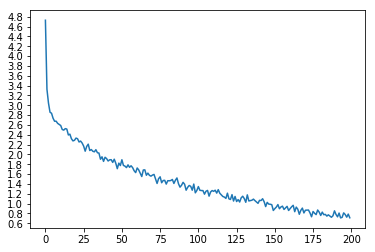

In [15]:
iters = 50000
train(encoder, decoder, iters, reverse_source_sentence=reverse_source_sentence, 
      use_teacher_forcing=use_teacher_forcing,print_every=250, plot_every=250)

In [16]:
# Randomly pick up 10 sentence and observe the performance
evaluate_randomly(encoder, decoder, 10, reverse_source_sentence)

> je suis tres fier de nos etudiants .
= i m very proud of our students .
< i m very proud of you . <EOS>

> vous etes faibles .
= you re weak .
< you re rude . <EOS>

> tu n es pas si vieux .
= you re not that old .
< you re not that old . <EOS>

> je songe a demissionner immediatement .
= i am thinking of resigning at once .
< i m thinking about the problem . <EOS>

> je suis en retard sur le programme .
= i m behind schedule .
< i m behind schedule . <EOS>

> je suis submerge de travail .
= i m swamped with work .
< i m proud of that . <EOS>

> je ne vais pas prendre le moindre risque .
= i m not taking any chances .
< i m not taking any chances . <EOS>

> je suis au restaurant .
= i m at the restaurant .
< i m in the office . <EOS>

> c est toi la doyenne .
= you re the oldest .
< you re the oldest . <EOS>

> je suis tres reconnaissant pour votre aide .
= i m very grateful for your help .
< i m very worried about you . <EOS>



## 作业-1
1. 注意到,Seq2seq的论文中，input sentence的输入是逆序的，实际上本实验课也是如此。
   按照论文的说法，如果是input sentence是顺序的，模型在同等条件下应该收敛速度可能会更慢。
   请运行 **train** 去检验该想法。
   (Hint: reverse_source_sentence 控制source sentence是否是逆序输入）
   
答：通过观察运行的结果，在句子是顺序和逆序两种情况下，实际上收敛速度差不多，没有明显的差距。

2. 注意到, 该课件decoder的输入，既可以是来自于targer sentence也可以是是来自于上一个时刻
   decoder的output。请运行 **train** 去看看有什么差别
   (Hint: reverse_source_sentence 控制source sentence是否是逆序输入）
   
答：可以发现不指定`use_teacher_forcing`的情况下，开始loss值会比上面模型的loss值要低，但是训练的效果不如上面的模型的训练效果，最终网络模型会比上面的模型略差。

3. 实际上decoder的激活函数除了relu，还可以选用tanh，请改变decoder的激活函数并且运行 **train**。

答：使用Tanh的一开始收敛速度会快于ReLU，但是最终网络模型的loss值都相差不大。

>> Model is on: True
>> Model is on: True
0m 15s (- 49m 58s) (250 0%) 4.6714
0m 28s (- 46m 57s) (500 1%) 3.4858
0m 46s (- 50m 48s) (750 1%) 3.2751
1m 2s (- 51m 9s) (1000 2%) 3.0976
1m 17s (- 50m 26s) (1250 2%) 3.0855
1m 30s (- 48m 57s) (1500 3%) 2.9952
1m 48s (- 49m 56s) (1750 3%) 2.9293
2m 3s (- 49m 23s) (2000 4%) 2.9101
2m 16s (- 48m 26s) (2250 4%) 2.8425
2m 30s (- 47m 34s) (2500 5%) 2.8138
2m 44s (- 47m 5s) (2750 5%) 2.7875
2m 57s (- 46m 25s) (3000 6%) 2.6527
3m 10s (- 45m 44s) (3250 6%) 2.6663
3m 24s (- 45m 10s) (3500 7%) 2.6896
3m 36s (- 44m 34s) (3750 7%) 2.6877
3m 49s (- 44m 4s) (4000 8%) 2.5639
4m 3s (- 43m 41s) (4250 8%) 2.5633
4m 17s (- 43m 19s) (4500 9%) 2.4649
4m 30s (- 42m 56s) (4750 9%) 2.4340
4m 44s (- 42m 40s) (5000 10%) 2.4237
5m 0s (- 42m 40s) (5250 10%) 2.4428
5m 14s (- 42m 24s) (5500 11%) 2.4482
5m 27s (- 42m 3s) (5750 11%) 2.3957
5m 41s (- 41m 41s) (6000 12%) 2.3834
5m 54s (- 41m 23s) (6250 12%) 2.3281
6m 9s (- 41m 12s) (6500 13%) 2.2984
6m 24s (- 41m 5s) (6750 13%

<Figure size 432x288 with 0 Axes>

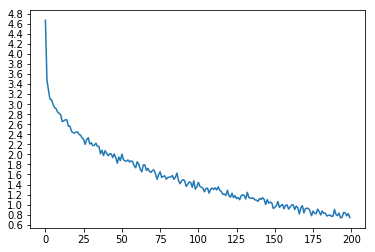

In [17]:
# Hw 1.1

setup_seed(45)
hidden_size = 256
# Reverse the order of source input sentence
reverse_source_sentence = False
# Feed the target as the next input
use_teacher_forcing = True
encoder = EncoderLSTM(input_lang.n_words, hidden_size).to(device)
decoder = DecoderLSTM(hidden_size, output_lang.n_words).to(device)
print(">> Model is on: {}".format(next(encoder.parameters()).is_cuda))
print(">> Model is on: {}".format(next(decoder.parameters()).is_cuda))

iters = 50000
train(encoder, decoder, iters, reverse_source_sentence=reverse_source_sentence, 
      use_teacher_forcing=use_teacher_forcing,print_every=250, plot_every=250)

>> Model is on: True
>> Model is on: True
0m 14s (- 49m 22s) (250 0%) 4.5025
0m 27s (- 45m 11s) (500 1%) 3.3029
0m 39s (- 43m 14s) (750 1%) 2.9893
0m 52s (- 42m 33s) (1000 2%) 2.8886
1m 6s (- 43m 10s) (1250 2%) 2.9643
1m 21s (- 43m 53s) (1500 3%) 2.8594
1m 35s (- 43m 40s) (1750 3%) 2.8643
1m 49s (- 43m 48s) (2000 4%) 2.7976
2m 2s (- 43m 24s) (2250 4%) 2.8458
2m 15s (- 42m 54s) (2500 5%) 2.8655
2m 29s (- 42m 54s) (2750 5%) 2.8859
2m 43s (- 42m 40s) (3000 6%) 2.7476
2m 57s (- 42m 38s) (3250 6%) 2.7577
3m 11s (- 42m 27s) (3500 7%) 2.7986
3m 26s (- 42m 22s) (3750 7%) 2.7935
3m 41s (- 42m 22s) (4000 8%) 2.7148
3m 56s (- 42m 20s) (4250 8%) 2.6984
4m 10s (- 42m 14s) (4500 9%) 2.6851
4m 26s (- 42m 14s) (4750 9%) 2.6087
4m 40s (- 42m 0s) (5000 10%) 2.5876
4m 53s (- 41m 42s) (5250 10%) 2.7120
5m 7s (- 41m 29s) (5500 11%) 2.6891
5m 21s (- 41m 13s) (5750 11%) 2.6112
5m 36s (- 41m 8s) (6000 12%) 2.6307
5m 52s (- 41m 5s) (6250 12%) 2.5999
6m 7s (- 40m 58s) (6500 13%) 2.5548
6m 20s (- 40m 39s) (6750 

<Figure size 432x288 with 0 Axes>

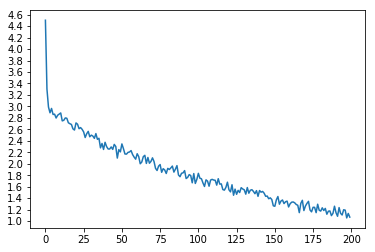

In [18]:
# Hw 1.2

setup_seed(45)
hidden_size = 256
# Reverse the order of source input sentence
reverse_source_sentence = True
# Feed the target as the next input
use_teacher_forcing = False
encoder = EncoderLSTM(input_lang.n_words, hidden_size).to(device)
decoder = DecoderLSTM(hidden_size, output_lang.n_words).to(device)
print(">> Model is on: {}".format(next(encoder.parameters()).is_cuda))
print(">> Model is on: {}".format(next(decoder.parameters()).is_cuda))

iters = 50000
train(encoder, decoder, iters, reverse_source_sentence=reverse_source_sentence, 
      use_teacher_forcing=use_teacher_forcing,print_every=250, plot_every=250)

In [21]:
# Hw 1.3
# TODO: change activation of DecoderLSTM firstly

class DecoderLSTM_v2(nn.Module):
    """Decoder use LSTM as backbone"""
    def __init__(self, hidden_size: int, output_size: int):
        """
        Args:
            hidden_size: The number of features in the hidden state 
            output_size : The number of expected features in the output 
        """
        super(DecoderLSTM_v2, self).__init__()
        self.hidden_size = hidden_size
        # Retrieve word embeddings with dimentionality hidden_size 
        # using indices with dimentionality input_size, embeddding is learnable
        # After embedding, input vector with input_size would be converted to hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        # LSTM
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        # out
        self.out = nn.Linear(hidden_size, output_size)
        # log after softmax
        self.log_softmax = nn.LogSoftmax(dim=1)
        # activation function, TODO!!
        self.activation_function = torch.tanh
        
    def forward(self, inputs, state):
        """Forward
        Args:
            inputs: [1, hidden_size]
            state : ([1, 1, hidden_size], [1, 1, hidden_size])
        Returns:
            output:
            state: (hidden, cell)
        """
        (hidden, cell) = state
        # Retrieve word embeddings, [1, 1, hidden_size]
        output = self.embedding(inputs).view(1, 1, -1)
        # activation function, [1, 1, hidden_size]
        output = self.activation_function(output)
        # output: [1, 1, hidden_size]
        output, (hidden, cell) = self.lstm(output, (hidden, cell))
        # output: [output_size]
        output = self.log_softmax(self.out(output[0]))
        return output, (hidden, cell)

    def init_hidden(self):
        """Init hidden
        Returns:
            hidden:
            cell:
        """
        cell = torch.zeros(1, 1, self.hidden_size, device=device)
        hidden = torch.zeros(1, 1, self.hidden_size, device=device)
        return hidden, cell

>> Model is on: True
>> Model is on: True
0m 15s (- 52m 49s) (250 0%) 5.4118
0m 29s (- 48m 55s) (500 1%) 3.4440
0m 42s (- 46m 57s) (750 1%) 3.1115
0m 55s (- 45m 34s) (1000 2%) 2.9068
1m 9s (- 45m 4s) (1250 2%) 2.8706
1m 22s (- 44m 33s) (1500 3%) 2.7711
1m 35s (- 43m 56s) (1750 3%) 2.7297
1m 48s (- 43m 27s) (2000 4%) 2.7282
2m 1s (- 42m 59s) (2250 4%) 2.6766
2m 15s (- 42m 47s) (2500 5%) 2.6640
2m 28s (- 42m 36s) (2750 5%) 2.6400
2m 42s (- 42m 20s) (3000 6%) 2.5584
2m 55s (- 42m 5s) (3250 6%) 2.5408
3m 9s (- 41m 56s) (3500 7%) 2.5797
3m 23s (- 41m 44s) (3750 7%) 2.5578
3m 36s (- 41m 32s) (4000 8%) 2.4568
3m 50s (- 41m 18s) (4250 8%) 2.4575
4m 3s (- 41m 1s) (4500 9%) 2.3789
4m 17s (- 40m 48s) (4750 9%) 2.3421
4m 31s (- 40m 45s) (5000 10%) 2.3405
4m 46s (- 40m 39s) (5250 10%) 2.3912
5m 0s (- 40m 28s) (5500 11%) 2.3813
5m 15s (- 40m 25s) (5750 11%) 2.3159
5m 29s (- 40m 16s) (6000 12%) 2.3369
5m 44s (- 40m 8s) (6250 12%) 2.2909
5m 57s (- 39m 55s) (6500 13%) 2.2288
6m 11s (- 39m 40s) (6750 13

<Figure size 432x288 with 0 Axes>

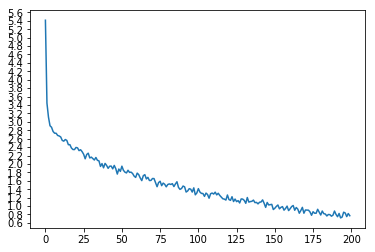

In [22]:
setup_seed(45)
hidden_size = 256
# Reverse the order of source input sentence
reverse_source_sentence = True
# Feed the target as the next input
use_teacher_forcing = True
encoder = EncoderLSTM(input_lang.n_words, hidden_size).to(device)
decoder = DecoderLSTM_v2(hidden_size, output_lang.n_words).to(device)
print(">> Model is on: {}".format(next(encoder.parameters()).is_cuda))
print(">> Model is on: {}".format(next(decoder.parameters()).is_cuda))

iters = 50000
train(encoder, decoder, iters, reverse_source_sentence=reverse_source_sentence, 
      use_teacher_forcing=use_teacher_forcing,print_every=250, plot_every=250)

## 1.2 Decoder with Attention
Why we need attention mechanism ?   
In short version, because seq2seq could achieve better performance and consumes less time with attention mechanism.   
In long version, attention allows the decoder network to “focus” on a different part of the encoder’s outputs for every step of the decoder’s own outputs.
For simplicity, we change **DecoderLSTM** to **AttentionDecoderLSTM** and some hepler function and then
we can train model.

**Very Detail of AttentionDecoderLSTM**  
Since there are many ways to do attention, we select a simple way to do that.  
First we calculate a set of attention weights.    
These will be multiplied by the encoder output vectors to create a weighted combination. 
The result (called attention_applied in the code) should contain information about that 
specific part of the input sequence, and thus help the decoder choose the right output words.

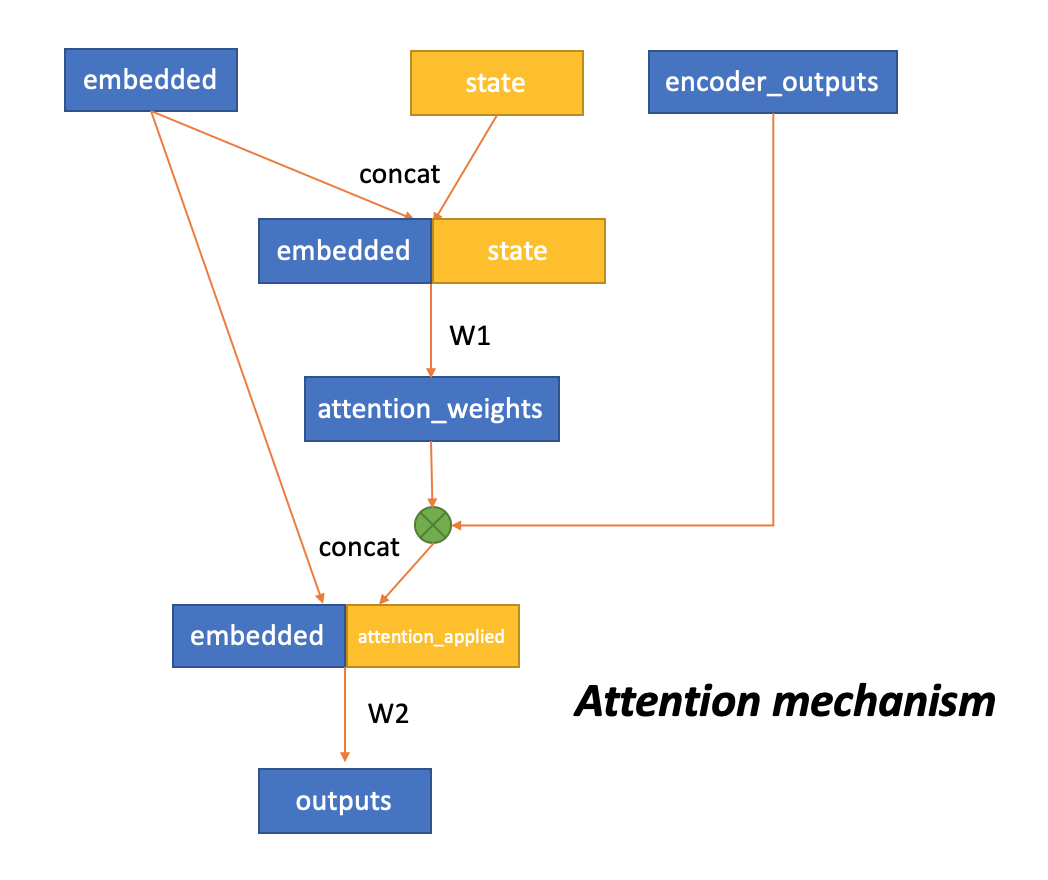

In [12]:
class AttentionDecoderLSTM(nn.Module):
    def __init__(self, hidden_size: int, output_size: int, dropout_p=0.1, max_length=MAX_LENGTH):
        """DecoderLSTM with attention mechanism
        """
        super(AttentionDecoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        # Retrieve word embeddings with dimentionality hidden_size 
        # using indices with dimentionality input_size, embeddding is learnable
        # After embedding, input vector with input_size would be converted to hidden_size
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        # W1 
        self.attention = nn.Linear(self.hidden_size * 2, self.max_length)
        # W2 
        self.attention_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size)
        # prediction layer 
        self.out = nn.Linear(self.hidden_size, self.output_size)
        # activation
        self.activation_fn = F.relu
        
    def forward(self, inputs, state, encoder_outputs):
        """Forward
        Args:
            inputs: [1, hidden_size]
            state : ([1, 1, hidden_size], [1, 1, hidden_size])
            encoder_outputs: [max_length, hidden_size]
        Returns:
            output:
            state: (hidden, cell)
        """
        # embedded: [1, 1, hidden_size]
        embedded = self.embedding(inputs).view(1, 1, -1)
        embedded = self.dropout(embedded)
        (hidden, cell) = state
       
        # attention_weights: [1, max_length]
        attention_weights = F.softmax(
            self.attention(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        # attention_applied: [1, hidden_size]
        # torch.bmm == @, matrix muplication
        attention_applied = torch.bmm(attention_weights.unsqueeze(0),
                                      encoder_outputs.unsqueeze(0))
        
        # output: [1, hidden_size * 2]
        output = torch.cat((embedded[0], attention_applied[0]), 1)
        # output: [1, 1, hidden_size]
        output = self.attention_combine(output).unsqueeze(0)
        
        output = self.activation_fn(output)
        # output, [1, 1, output_size]
        output, (hidden, cell) = self.lstm(output, (hidden, cell))
        
        # output, [1, output_size]
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, (hidden, cell), attention_weights
    
    def init_hidden(self):
        """Init hidden
        Returns:
            hidden:
            cell:
        """
        cell = torch.zeros(1, 1, self.hidden_size, device=device)
        hidden = torch.zeros(1, 1, self.hidden_size, device=device)
        return hidden, cell

In [13]:
def train_by_sentence_attn(input_tensor, target_tensor, encoder, decoder, 
                      encoder_optimizer, decoder_optimizer, loss_fn, 
                      use_teacher_forcing=True, reverse_source_sentence=True,
                      max_length=MAX_LENGTH):
    """Train by single sentence using EncoderLSTM and DecoderLSTM
       including training and update model, combining attention mechanism.
    Args:
        input_tensor: [input_sequence_len, 1, hidden_size]
        target_tensor: [target_sequence_len, 1, hidden_size]
        encoder: EncoderLSTM
        decoder: DecoderLSTM
        encoder_optimizer: optimizer for encoder
        decoder_optimizer: optimizer for decoder
        loss_fn: loss function
        use_teacher_forcing: True is to Feed the target as the next input, 
                             False is to use its own predictions as the next input
        max_length: max length for input and output
    Returns:
        loss: scalar
    """
    if reverse_source_sentence:
        input_tensor = torch.flip(input_tensor, [0])
        
    hidden, cell = encoder.init_hidden()

    # Clears the gradients of all optimized torch.Tensors'
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Get sequence length of the input and target sentences.
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    # encoder outputs:  [max_length, hidden_size]
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    # Get encoder outputs
    for ei in range(input_length):
        encoder_output, (hidden, cell) = encoder(
            input_tensor[ei], (hidden, cell))
        encoder_outputs[ei] = encoder_output[0, 0]
    
    # First input for the decoder
    decoder_input = torch.tensor([[SOS_token]], device=device)
    
    # Last state of encoder as the init state of decoder
    decoder_hidden = (hidden, cell)

    for di in range(target_length):
        # !! Most important change, apply attention mechnism 
        decoder_output, (hidden, cell), _ = decoder(
            decoder_input, (hidden, cell), encoder_outputs)
        
        if use_teacher_forcing:
            # Feed the target as the next input
            loss += loss_fn(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing
        else:
            # Use its own predictions as the next input
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()
            loss += loss_fn(decoder_output, target_tensor[di])

        # End if decoder output End of Signal(EOS)
        if decoder_input.item() == EOS_token:
            break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [14]:
def train_attn(encoder, decoder, n_iters, reverse_source_sentence=True, 
          use_teacher_forcing=True,
          print_every=1000, plot_every=100, 
          learning_rate=0.01):
    """Train of Seq2seq with attention 
    Args:
        encoder: EncoderLSTM
        decoder: DecoderLSTM
        n_iters: train with n_iters sentences without replacement
        reverse_source_sentence: True is to reverse the source sentence 
                                 but keep order of target unchanged,
                                 False is to keep order of the source sentence 
                                 target unchanged
        use_teacher_forcing: True is to Feed the target as the next input, 
                             False is to use its own predictions as the next input
        print_every: print log every print_every 
        plot_every: plot every plot_every 
        learning_rate: 
        
    """
    
    start = time.time()
    
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0

    # Use SGD to optimize encoder and decoder parameters
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    # Obtain training input 
    training_pairs = [tensor_from_pair(random.choice(pairs), input_lang, output_lang)
                      for _ in range(n_iters)]
    
    # Negative log likelihood loss
    loss_fn = nn.NLLLoss()

    for i in range(1, n_iters+1):
        # Get a pair of sentences and move them to device, 
        # training_pair: ([Seq_size, 1, input_size], [Seq_size, 1, input_size])
        training_pair = training_pairs[i-1]
        input_tensor = training_pair[0].to(device)
        target_tensor = training_pair[1].to(device)            
            
        # Train by a pair of source sentence and target sentence
        loss = train_by_sentence_attn(input_tensor, target_tensor, 
                                      encoder, decoder,
                                      encoder_optimizer, decoder_optimizer, 
                                      loss_fn, use_teacher_forcing=use_teacher_forcing,
                                      reverse_source_sentence=reverse_source_sentence)
        
        print_loss_total += loss
        plot_loss_total += loss

        if i % print_every == 0:
            # Print Loss
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print("%s (%d %d%%) %.4f" % (time_since(start, i / n_iters),
                                         i, i / n_iters * 100, print_loss_avg))

        if i % plot_every == 0:
            # Plot
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    
    # show plot
    show_plot(plot_losses)

In [15]:
def evaluate_by_sentence_attn(encoder, decoder, sentence, 
                              reverse_source_sentence=True, max_length=MAX_LENGTH):
    """Evalutae on a source sentence with model trained with attention mechanism
    Args:
        encoder
        decoder
        sentence
        max_length
    Return:
        decoded_words: predicted sentence
    """
    with torch.no_grad():
        # Get tensor of sentence
        input_tensor = tensor_from_sentence(input_lang, sentence).to(device)
        input_length = input_tensor.size(0)
        
        if reverse_source_sentence:
            input_tensor = torch.flip(input_tensor, [0])
        
        # init state for encoder
        (hidden, cell) = encoder.init_hidden()

        # encoder outputs: [max_length, hidden_size]
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, (hidden, cell) = encoder(input_tensor[ei],
                                                     (hidden, cell))
            encoder_outputs[ei] += encoder_output[0, 0]
            
        # Last state of encoder as the init state of decoder
        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = (hidden, cell)
        decoded_words = []
        
        # CHANGE!! Add decoder_attentions to collect attention map
        decoder_attentions = torch.zeros(max_length, max_length)

        # When evaluate, use its own predictions as the next input
        for di in range(max_length):
            # CHANGE!! Attention
            decoder_output, (hidden, cell), decoder_attention = \
                decoder(decoder_input, (hidden, cell), encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            # CHANGE!!
            decoder_attentions[di] = decoder_attention.data
            if topi.item() == EOS_token:
                decoded_words.append("<EOS>")
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])
                
            decoder_input = topi.squeeze().detach()

    return decoded_words, decoder_attentions[:di + 1]

In [16]:
def show_attention(input_sentence, output_words, attentions):
    """Show attention between input sentence and output words
    """
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [17]:
def evaluate_and_show_attention(input_sentence, encoder, decoder):
    """Evaluate and show attention for a input sentence
    """
    output_words, attentions = evaluate_by_sentence_attn(
        encoder, decoder, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    show_attention(input_sentence, output_words, attentions)

In [20]:
setup_seed(45)
hidden_size = 256
# Reverse the order of source input sentence
reverse_source_sentence = True
# Feed the target as the next input
use_teacher_forcing = True
encoder = EncoderLSTM(input_lang.n_words, hidden_size).to(device)
decoder = AttentionDecoderLSTM(hidden_size, output_lang.n_words).to(device)
print(">> Model is on: {}".format(next(encoder.parameters()).is_cuda))
print(">> Model is on: {}".format(next(decoder.parameters()).is_cuda))

>> Model is on: True
>> Model is on: True


0m 23s (- 77m 56s) (250 0%) 4.9045
0m 41s (- 68m 39s) (500 1%) 3.3049
1m 0s (- 65m 48s) (750 1%) 3.0303
1m 17s (- 63m 40s) (1000 2%) 2.8569
1m 36s (- 62m 31s) (1250 2%) 2.8321
1m 54s (- 61m 38s) (1500 3%) 2.7320
2m 11s (- 60m 23s) (1750 3%) 2.6652
2m 28s (- 59m 34s) (2000 4%) 2.6601
2m 46s (- 58m 53s) (2250 4%) 2.6078
3m 10s (- 60m 10s) (2500 5%) 2.5934
3m 30s (- 60m 12s) (2750 5%) 2.5855
3m 49s (- 60m 2s) (3000 6%) 2.4951
4m 12s (- 60m 35s) (3250 6%) 2.4717
4m 32s (- 60m 23s) (3500 7%) 2.4963
4m 54s (- 60m 38s) (3750 7%) 2.4969
5m 15s (- 60m 30s) (4000 8%) 2.3994
5m 35s (- 60m 11s) (4250 8%) 2.3991
5m 55s (- 59m 56s) (4500 9%) 2.3072
6m 17s (- 59m 53s) (4750 9%) 2.2703
6m 38s (- 59m 48s) (5000 10%) 2.2681
6m 56s (- 59m 8s) (5250 10%) 2.3253
7m 15s (- 58m 47s) (5500 11%) 2.3062
7m 35s (- 58m 24s) (5750 11%) 2.2431
7m 54s (- 58m 2s) (6000 12%) 2.2481
8m 14s (- 57m 38s) (6250 12%) 2.2147
8m 34s (- 57m 20s) (6500 13%) 2.1789
8m 52s (- 56m 54s) (6750 13%) 2.0689
9m 12s (- 56m 31s) (7000 14

<Figure size 432x288 with 0 Axes>

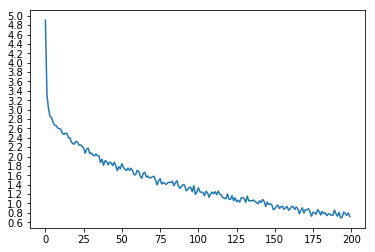

In [21]:
iters = 50000
train_attn(encoder, decoder, iters, reverse_source_sentence=reverse_source_sentence, 
           use_teacher_forcing=use_teacher_forcing,print_every=250, plot_every=250)

input = elle a cinq ans de moins que moi .
output = she is two years younger than me . <EOS>


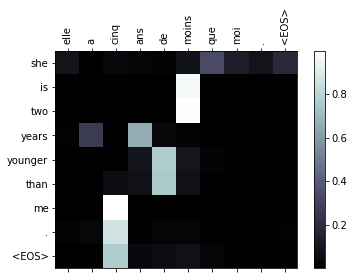

input = elle est trop petit .
output = she is too drunk . <EOS>


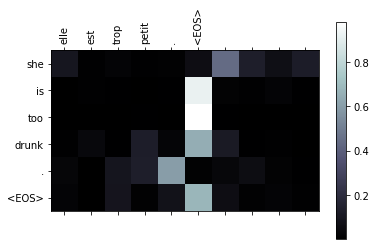

input = je ne crains pas de mourir .
output = i m not afraid of making mistakes . <EOS>


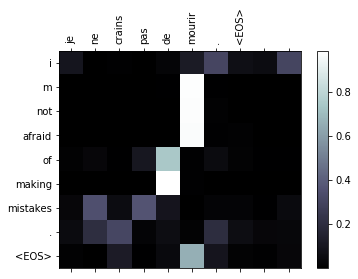

input = c est un jeune directeur plein de talent .
output = he s a very talented writer . <EOS>


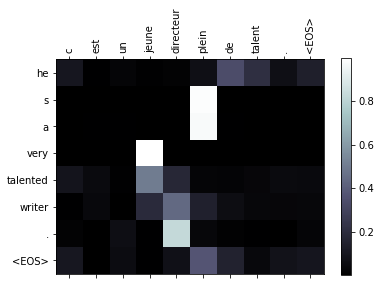

In [22]:
evaluate_and_show_attention("elle a cinq ans de moins que moi .", encoder, decoder)

evaluate_and_show_attention("elle est trop petit .", encoder, decoder)

evaluate_and_show_attention("je ne crains pas de mourir .", encoder, decoder)

evaluate_and_show_attention("c est un jeune directeur plein de talent .", encoder, decoder)

## 2.1 Diving into LSTM 

## 2.1.1 Implement your own LSTM from scratch using pytorch

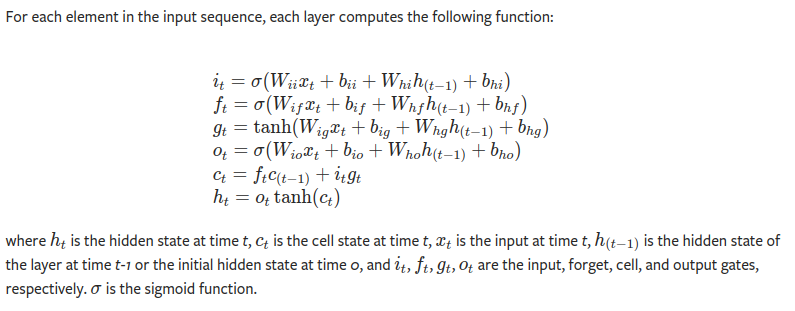

**@** 指的是 matrix mipliplication

In [23]:
class NaiveLSTM(nn.Module):
    """Naive LSTM like nn.LSTM"""
    def __init__(self, input_size: int, hidden_size: int):
        super(NaiveLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # input gate
        self.w_ii = Parameter(Tensor(hidden_size, input_size))
        self.w_hi = Parameter(Tensor(hidden_size, hidden_size))
        self.b_ii = Parameter(Tensor(hidden_size, 1))
        self.b_hi = Parameter(Tensor(hidden_size, 1))

        # forget gate
        self.w_if = Parameter(Tensor(hidden_size, input_size))
        self.w_hf = Parameter(Tensor(hidden_size, hidden_size))
        self.b_if = Parameter(Tensor(hidden_size, 1))
        self.b_hf = Parameter(Tensor(hidden_size, 1))

        # output gate
        self.w_io = Parameter(Tensor(hidden_size, input_size))
        self.w_ho = Parameter(Tensor(hidden_size, hidden_size))
        self.b_io = Parameter(Tensor(hidden_size, 1))
        self.b_ho = Parameter(Tensor(hidden_size, 1))
        
        # cell
        self.w_ig = Parameter(Tensor(hidden_size, input_size))
        self.w_hg = Parameter(Tensor(hidden_size, hidden_size))
        self.b_ig = Parameter(Tensor(hidden_size, 1))
        self.b_hg = Parameter(Tensor(hidden_size, 1))

        self.reset_weigths()

    def reset_weigths(self):
        """reset weights
        """
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            init.uniform_(weight, -stdv, stdv)

    def forward(self, inputs: Tensor, state: Tuple[Tensor]) \
        -> Tuple[Tensor, Tuple[Tensor, Tensor]]:
        """Forward
        Args:
            inputs: [1, 1, input_size]
            state: ([1, 1, hidden_size], [1, 1, hidden_size])
        """

#         seq_size, batch_size, _ = inputs.size()

        if state is None:
            h_t = torch.zeros(1, self.hidden_size).t()
            c_t = torch.zeros(1, self.hidden_size).t()
        else:
            (h, c) = state
            h_t = h.squeeze(0).t()
            c_t = c.squeeze(0).t()

        hidden_seq = []

        seq_size = 1
        for t in range(seq_size):
            x = inputs[:, t, :].t()
            # input gate
            i = torch.sigmoid(self.w_ii @ x + self.b_ii + self.w_hi @ h_t +
                              self.b_hi)
            # forget gate
            f = torch.sigmoid(self.w_if @ x + self.b_if + self.w_hf @ h_t +
                              self.b_hf)
            # cell
            g = torch.tanh(self.w_ig @ x + self.b_ig + self.w_hg @ h_t
                           + self.b_hg)
            # output gate
            o = torch.sigmoid(self.w_io @ x + self.b_io + self.w_ho @ h_t +
                              self.b_ho)
            
            c_next = f * c_t + i * g
            h_next = o * torch.tanh(c_next)
            c_next_t = c_next.t().unsqueeze(0)
            h_next_t = h_next.t().unsqueeze(0)
            hidden_seq.append(h_next_t)

        hidden_seq = torch.cat(hidden_seq, dim=0)
        return hidden_seq, (h_next_t, c_next_t)

In [24]:
def reset_weigths(model):
    """reset weights
    """
    for weight in model.parameters():
        init.constant_(weight, 0.5)

In [25]:
inputs = torch.ones(1, 1, 10)
h0 = torch.ones(1, 1, 20)
c0 = torch.ones(1, 1, 20)
print(h0.shape, h0)
print(c0.shape, c0)
print(inputs.shape, inputs)

torch.Size([1, 1, 20]) tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1.]]])
torch.Size([1, 1, 20]) tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1.]]])
torch.Size([1, 1, 10]) tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]])


In [26]:
# test naive_lstm with input_size=10, hidden_size=20
naive_lstm = NaiveLSTM(10, 20)
reset_weigths(naive_lstm)

In [27]:
output1, (hn1, cn1) = naive_lstm(inputs, (h0, c0))

In [28]:
print(hn1.shape, cn1.shape, output1.shape)
print(hn1)
print(cn1)
print(output1)

torch.Size([1, 1, 20]) torch.Size([1, 1, 20]) torch.Size([1, 1, 20])
tensor([[[0.9640, 0.9640, 0.9640, 0.9640, 0.9640, 0.9640, 0.9640, 0.9640,
          0.9640, 0.9640, 0.9640, 0.9640, 0.9640, 0.9640, 0.9640, 0.9640,
          0.9640, 0.9640, 0.9640, 0.9640]]], grad_fn=<UnsqueezeBackward0>)
tensor([[[2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
          2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
          2.0000, 2.0000, 2.0000, 2.0000]]], grad_fn=<UnsqueezeBackward0>)
tensor([[[0.9640, 0.9640, 0.9640, 0.9640, 0.9640, 0.9640, 0.9640, 0.9640,
          0.9640, 0.9640, 0.9640, 0.9640, 0.9640, 0.9640, 0.9640, 0.9640,
          0.9640, 0.9640, 0.9640, 0.9640]]], grad_fn=<CatBackward>)


## 2.1.2 Compare with Official LSTM

In [29]:
# Use official lstm with input_size=10, hidden_size=20
lstm = nn.LSTM(10, 20)
reset_weigths(lstm)

In [30]:
output2, (hn2, cn2) = lstm(inputs, (h0, c0))
print(hn2.shape, cn2.shape, output2.shape)
print(hn2)
print(cn2)
print(output2)

torch.Size([1, 1, 20]) torch.Size([1, 1, 20]) torch.Size([1, 1, 20])
tensor([[[0.9640, 0.9640, 0.9640, 0.9640, 0.9640, 0.9640, 0.9640, 0.9640,
          0.9640, 0.9640, 0.9640, 0.9640, 0.9640, 0.9640, 0.9640, 0.9640,
          0.9640, 0.9640, 0.9640, 0.9640]]], grad_fn=<StackBackward>)
tensor([[[2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
          2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
          2.0000, 2.0000, 2.0000, 2.0000]]], grad_fn=<StackBackward>)
tensor([[[0.9640, 0.9640, 0.9640, 0.9640, 0.9640, 0.9640, 0.9640, 0.9640,
          0.9640, 0.9640, 0.9640, 0.9640, 0.9640, 0.9640, 0.9640, 0.9640,
          0.9640, 0.9640, 0.9640, 0.9640]]], grad_fn=<StackBackward>)


## 2.2 Observing the Grad Vanishing of LSTM and RNN 

In [31]:
# Implementation of RNN for our experiment 
from NaiveRNN import NaiveRNN

In [32]:
hidden_size = 50
input_size = 100
sequence_len = 100
high = 1000000

In [33]:
# Generate random input with sequence_len=100
test_idx = torch.randint(high=high, size=(1, sequence_len)).to(device)
print(test_idx)

tensor([[467641, 438165, 935784, 348843, 456126, 678722, 544521, 629650, 913052,
         515704, 359498, 813691,  85030, 812238,  81280, 534390, 213301, 739639,
         946166, 142993, 176025, 324614, 504309, 253316,  20391, 536403, 934167,
         390225, 640486, 736492, 462829, 287346, 267072, 136907, 162403, 581682,
         251738, 852900, 377706,  95229, 817013, 533409, 486543, 639531, 823225,
         393774, 451828, 300227, 620261, 894586, 392700, 298598, 399744, 551383,
         934141, 695864, 855742, 290926, 663304, 578266, 672847, 429797, 580725,
         394330, 248653,  28963, 842417, 337341, 445876, 271879, 831151, 824026,
         226680, 804180, 468878, 716080, 324929, 540810, 686717, 493021, 133503,
         913081, 488010, 758172, 446451, 518270, 381352, 378181, 296251, 519946,
         205581, 921540, 626297, 817562, 742148, 732258, 934476, 589189, 638731,
         298330]], device='cuda:0')


In [34]:
setup_seed(45)
embeddings = nn.Embedding(high, input_size).to(device)
test_embeddings = embeddings(test_idx).to(device)
print(test_embeddings)

h_0 = torch.zeros(1, hidden_size, requires_grad=True).to(device)
h_t = h_0
print(h_0)
print(test_embeddings)

tensor([[[ 0.5697,  0.7304, -0.4647,  ...,  0.7549,  0.3112, -0.4582],
         [ 1.5171,  0.7328,  0.0803,  ...,  1.2385,  1.2259, -0.5259],
         [-0.2804, -0.4395,  1.5441,  ..., -0.8644,  0.1858, -0.9446],
         ...,
         [ 0.5019, -0.8431, -0.9560,  ...,  0.2607,  1.2035,  0.6892],
         [-0.5062,  0.8530,  0.3743,  ..., -0.4148, -0.3384,  0.9264],
         [-2.1523,  0.6292, -0.9732,  ..., -0.2591, -1.6320, -0.1915]]],
       device='cuda:0', grad_fn=<EmbeddingBackward>)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], device='cuda:0', grad_fn=<CopyBackwards>)
tensor([[[ 0.5697,  0.7304, -0.4647,  ...,  0.7549,  0.3112, -0.4582],
         [ 1.5171,  0.7328,  0.0803,  ...,  1.2385,  1.2259, -0.5259],
         [-0.2804, -0.4395,  1.5441,  ..., -0.8644,  0.1858, -0.9446],
         ...,
       

## 2.2.1 Grad of RNN

In [35]:
def rnn_step(x, h, w_ih, b_ih, w_hh, b_hh):
    """run rnn a step
    """
    h = torch.tanh(w_ih @ x.t() + b_ih + w_hh @ h.t() + b_hh)
    h_t = h.t()
    return h_t

In [36]:
print(test_embeddings)

rnn = NaiveRNN(input_size, hidden_size).to(device)
iters = test_embeddings.size(1)
rnn_grads = []
for t in range(iters):
    h_t = rnn_step(test_embeddings[: , t, :], h_t, 
                           rnn.w_ih, rnn.b_ih, rnn.w_hh, rnn.b_hh)
    loss = h_t.abs().sum()
    h_0.retain_grad()
    loss.backward(retain_graph=True)
    rnn_grads.append(torch.norm(h_0.grad).item())
    h_0.grad.zero_()
    rnn.zero_grad()

tensor([[[ 0.5697,  0.7304, -0.4647,  ...,  0.7549,  0.3112, -0.4582],
         [ 1.5171,  0.7328,  0.0803,  ...,  1.2385,  1.2259, -0.5259],
         [-0.2804, -0.4395,  1.5441,  ..., -0.8644,  0.1858, -0.9446],
         ...,
         [ 0.5019, -0.8431, -0.9560,  ...,  0.2607,  1.2035,  0.6892],
         [-0.5062,  0.8530,  0.3743,  ..., -0.4148, -0.3384,  0.9264],
         [-2.1523,  0.6292, -0.9732,  ..., -0.2591, -1.6320, -0.1915]]],
       device='cuda:0', grad_fn=<EmbeddingBackward>)


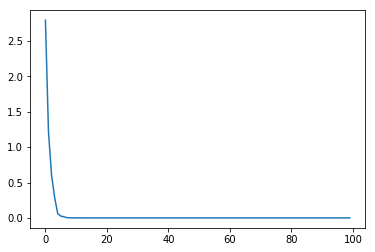

In [37]:
plt.plot(rnn_grads)

## 2.2.1 Grad of LSTM

In [38]:
def show_gates(i_s, o_s, f_s):
    """Show input gate, output gate, forget gate for LSTM
    """
    plt.plot(i_s, "r", label="input gate")
    plt.plot(o_s, "b", label="output gate")
    plt.plot(f_s, "g", label="forget gate")
    plt.title('Input gate, output gate and forget gate of LSTM')
    plt.xlabel('t', color='#1C2833')
    plt.ylabel('Mean Value', color='#1C2833')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [39]:
def lstm_step(x, h, c, w_ii, b_ii, w_hi, b_hi,
                  w_if, b_if, w_hf, b_hf,
                  w_ig, b_ig, w_hg, b_hg,
                  w_io, b_io, w_ho, b_ho, use_forget_gate=True):
    """run lstm a step
    """
    x_t = x.t()
    h_t = h.t()
    c_t = c.t()
    i = torch.sigmoid(w_ii @ x_t + b_ii + w_hi @ h_t + b_hi)
    o = torch.sigmoid(w_io @ x_t + b_io + w_ho @ h_t + b_ho)
    g = torch.tanh(w_ig @ x_t + b_ig + w_hg @ h_t + b_hg)
    f = torch.sigmoid(w_if @ x_t + b_if + w_hf @ h_t + b_hf)
    if use_forget_gate:
        c_next = f * c_t + i * g
    else:
        c_next = c_t + i * g
    h_next = o * torch.tanh(c_next)
    c_next_t = c_next.t()
    h_next_t = h_next.t()
    
    i_avg = torch.mean(i).detach()
    o_avg = torch.mean(o).detach()
    f_avg = torch.mean(f).detach()
    
    return h_next_t, c_next_t, f_avg, i_avg, o_avg

In [40]:
setup_seed(45)
embeddings = nn.Embedding(high, input_size).to(device)
test_embeddings = embeddings(test_idx).to(device)
h_0 = torch.zeros(1, hidden_size, requires_grad=True).to(device)
c_0 = torch.zeros(1, hidden_size, requires_grad=True).to(device)
h_t = h_0
c_t = c_0
print(test_embeddings)
print(h_0)
print(c_0)

tensor([[[ 0.5697,  0.7304, -0.4647,  ...,  0.7549,  0.3112, -0.4582],
         [ 1.5171,  0.7328,  0.0803,  ...,  1.2385,  1.2259, -0.5259],
         [-0.2804, -0.4395,  1.5441,  ..., -0.8644,  0.1858, -0.9446],
         ...,
         [ 0.5019, -0.8431, -0.9560,  ...,  0.2607,  1.2035,  0.6892],
         [-0.5062,  0.8530,  0.3743,  ..., -0.4148, -0.3384,  0.9264],
         [-2.1523,  0.6292, -0.9732,  ..., -0.2591, -1.6320, -0.1915]]],
       device='cuda:0', grad_fn=<EmbeddingBackward>)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], device='cuda:0', grad_fn=<CopyBackwards>)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], devic

## 2.2.2.1 Grad of LSTM (Not Using forget gate)

In [41]:
lstm = NaiveLSTM(input_size, hidden_size).to(device)
iters = test_embeddings.size(1)
lstm_grads = []
i_s = []
o_s = []
f_s = []
for t in range(iters):
    h_t, c_t, f, i, o = lstm_step(test_embeddings[: , t, :], h_t, c_t, 
                               lstm.w_ii, lstm.b_ii, lstm.w_hi, lstm.b_hi,
                               lstm.w_if, lstm.b_if, lstm.w_hf, lstm.b_hf,
                               lstm.w_ig, lstm.b_ig, lstm.w_hg, lstm.b_hg,
                               lstm.w_io, lstm.b_io, lstm.w_ho, lstm.b_ho,
                               use_forget_gate=False)
    loss = h_t.abs().sum()
    h_0.retain_grad()
    loss.backward(retain_graph=True)
    lstm_grads.append(torch.norm(h_0.grad).item())
    i_s.append(i)
    o_s.append(o)
    f_s.append(f)
    h_0.grad.zero_()
    lstm.zero_grad()

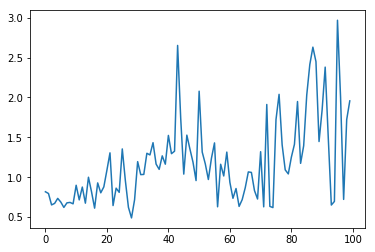

In [42]:
plt.plot(lstm_grads)

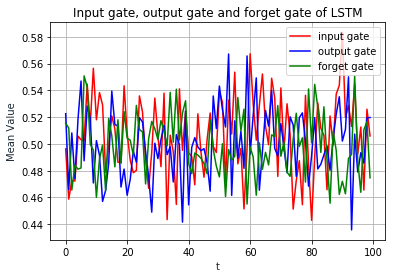

In [43]:
show_gates(i_s, o_s, f_s)

## 2.2.2.2 Grad of LSTM (Using forget gate)

In [44]:
setup_seed(45)
embeddings = nn.Embedding(high, input_size).to(device)
test_embeddings = embeddings(test_idx).to(device)
h_0 = torch.zeros(1, hidden_size, requires_grad=True).to(device)
c_0 = torch.zeros(1, hidden_size, requires_grad=True).to(device)
h_t = h_0
c_t = c_0
print(test_embeddings)
print(h_0)
print(c_0)

tensor([[[ 0.5697,  0.7304, -0.4647,  ...,  0.7549,  0.3112, -0.4582],
         [ 1.5171,  0.7328,  0.0803,  ...,  1.2385,  1.2259, -0.5259],
         [-0.2804, -0.4395,  1.5441,  ..., -0.8644,  0.1858, -0.9446],
         ...,
         [ 0.5019, -0.8431, -0.9560,  ...,  0.2607,  1.2035,  0.6892],
         [-0.5062,  0.8530,  0.3743,  ..., -0.4148, -0.3384,  0.9264],
         [-2.1523,  0.6292, -0.9732,  ..., -0.2591, -1.6320, -0.1915]]],
       device='cuda:0', grad_fn=<EmbeddingBackward>)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], device='cuda:0', grad_fn=<CopyBackwards>)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], devic

In [45]:
lstm = NaiveLSTM(input_size, hidden_size).to(device)
## BIG CHANGE!!
lstm.b_hf.data = torch.ones_like(lstm.b_hf) * 1/2
lstm.b_if.data = torch.ones_like(lstm.b_if) * 1/2
iters = test_embeddings.size(1)
lstm_grads = []
i_s = []
o_s = []
f_s = []
for t in range(iters):
    h_t, c_t, f, i, o = lstm_step(test_embeddings[: , t, :], h_t, c_t, 
                               lstm.w_ii, lstm.b_ii, lstm.w_hi, lstm.b_hi,
                               lstm.w_if, lstm.b_if, lstm.w_hf, lstm.b_hf,
                               lstm.w_ig, lstm.b_ig, lstm.w_hg, lstm.b_hg,
                               lstm.w_io, lstm.b_io, lstm.w_ho, lstm.b_ho,
                               use_forget_gate=True)
    loss = h_t.abs().sum()
    h_0.retain_grad()
    loss.backward(retain_graph=True)
    lstm_grads.append(torch.norm(h_0.grad).item())
    i_s.append(i)
    o_s.append(o)
    f_s.append(f)
    h_0.grad.zero_()
    lstm.zero_grad()

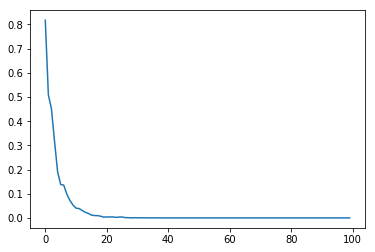

In [46]:
plt.plot(lstm_grads)

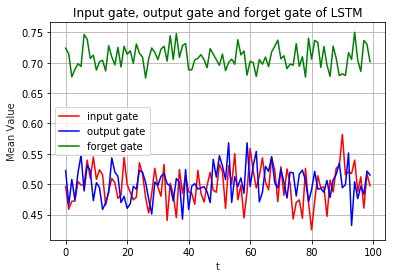

In [47]:
show_gates(i_s, o_s, f_s)

Reference
--------

1. [Seq2seq](https://github.com/bentrevett/pytorch-seq2seq)
2. [building-an-lstm-from-scratch-in-pytorch-lstms-in-depth-part-1](http://mlexplained.com/2019/02/15/building-an-lstm-from-scratch-in-pytorch-lstms-in-depth-part-1/)
3. [seq2seq_translation_tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)
4. [Understanding-LSTMs](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
5. [pytorch-seq2seq](https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb)

## 做了无加分的作业 
1. 使用GRU加速Seq2seq的训练速度。请简单修改以下几个函数，不要改变函数形参。并且重复使用它重复作业1.1。 (5+4个cell)  
   Hints: 相对LSTM，GRU做了优化。它将LSTM的两个输入hidden和cell用同一个参数hidden表示。目的是降低计算开销，劣势是会牺牲一定的精度。
2. 简答，课件实现的seq2seq和 [Sequence to Sequence Learning
with Neural Networks](https://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf) 的有什么差别？论文中模型训练开销是多久？有什么简单的办法可以提升训练速度吗？（开放性问题， 1个cell）

```
EncoderLSTM -> EncoderGRU, 将nn.LSTM换成nn.GRU
DecoderLSTM -> DecoderGRU, 将nn.LSTM换成nn.GRU
train_by_sentence -> train_by_sentence_v2      
train -> train_v2
evaluate -> train_v2
```
 